In [1]:
import pandas as pd
import numpy as np
import itertools
from itertools import combinations
import matplotlib.pyplot as plt
from scipy.stats import poisson

In [3]:
# import team list from the european chamipionship 2024

data_teams = pd.read_excel("./data/em_teams.xlsx")
data_teams = data_teams.replace('Tschechische Republik', 'Tschechien')
data_teams


,Land,Gruppe
0,Deutschland,A
1,Schottland,A
2,Ungarn,A
3,Schweiz,A
4,Spanien,B
5,Kroatien,B
6,Italien,B
7,Albanien,B
8,Slowenien,C
9,Dänemark,C


In [4]:
data_goals_23 = pd.read_excel("./data/EM quali 22 23.xlsx", header=None, names=["Land", "Tore"])
data_goals_19 = pd.read_excel("./data/EM quali 18 19.xlsx", header=None, names=["Land", "Tore"])
data_goals_15 = pd.read_excel("./data/EM quali 14 15.xlsx", header=None, names=["Land", "Tore"])
data_goals_11 = pd.read_excel("./data/EM quali 10 11.xlsx", header=None, names=["Land", "Tore"])

data_goals_merged = pd.concat([data_goals_23, data_goals_19, data_goals_15, data_goals_11], ignore_index=True)
data_goals_merged = data_goals_merged[data_goals_merged['Land'].isin(data_teams['Land'])]
print(data_goals_merged)


            Land  Tore
0     Schottland     3
1        Spanien     3
2       Georgien     1
3     Schottland     2
6     Schottland     2
...          ...   ...
1873  Tschechien     2
1876     Spanien     2
1877  Schottland     1
1878  Tschechien     4
1879  Schottland     1

[798 rows x 2 columns]


In [5]:
data_goals = {}

for land, tore in data_goals_merged.groupby('Land')['Tore']:
    # Die Tore als Liste speichern
    data_goals[land] = list(tore)

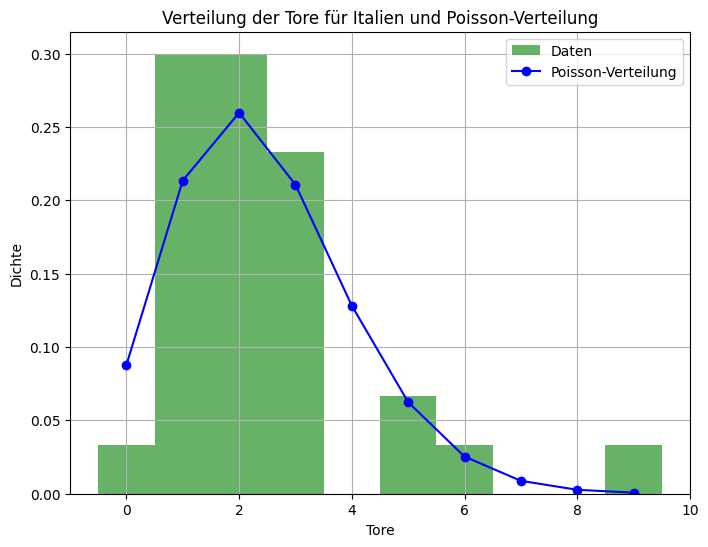

In [10]:
# Histogramm für ein Land erstellen
land = 'Italien'
tore = data_goals[land]

# Bestimme die maximale Anzahl von Toren
max_tore = max(tore)

# Schätze die Parameter der Poisson-Verteilung
mu = np.mean(tore)

# Erzeuge eine Poisson-Verteilung mit den geschätzten Parametern
poisson_dist = poisson(mu)

# Erzeuge das Histogramm der Tore
plt.figure(figsize=(8, 6))
plt.hist(tore, bins=max_tore+1, range=(-0.5, max_tore+0.5), density=True, alpha=0.6, color='g', label='Daten')

# Erzeuge die Poisson-Verteilungskurve
x_values = np.arange(0, max_tore+1)
plt.plot(x_values, poisson_dist.pmf(x_values), 'bo-', label='Poisson-Verteilung')

# Diagrammbeschriftung
plt.title(f'Verteilung der Tore für {land} und Poisson-Verteilung')
plt.xlabel('Tore')
plt.ylabel('Dichte')
plt.legend()
plt.grid(True)
plt.show()

In [11]:
#Gewinner durch Poisson-Verteilung
def win_goals(data, country_a, country_b):
    mu_a = np.mean(data[country_a])
    mu_b = np.mean(data[country_b])

    poisson_dist_a = poisson(mu_a)
    poisson_dist_b = poisson(mu_b)

    tore_a = poisson_dist_a.rvs()
    tore_b = poisson_dist_b.rvs()

    return tore_a, tore_b


In [12]:
def simulate_game_group(data, country_a, country_b):
    tore_a, tore_b = win_goals(data, country_a, country_b)
    punkte_a = 0
    punkte_b = 0
    if tore_a > tore_b:
        punkte_a = 3
    elif tore_a < tore_b:
        punkte_b = 3
    else:
        punkte_a = 1
        punkte_b = 1

    return punkte_a, punkte_b, tore_a, tore_b

def simulate_game_ko(data, country_a, country_b):
    while True:
        tore_a, tore_b = win_goals(data, country_a, country_b)
        if tore_a > tore_b:
            return country_a
        elif tore_a < tore_b:
            return country_b
        else:
            continue



In [13]:
def simulate_group(data, group=str):
    # DataFrame für die spezifische Gruppe filtern
    filtered_df = data_teams[data_teams['Gruppe'] == group].copy()

    # Neue Spalten für Punkte und Tordifferenz hinzufügen und auf Null initialisieren
    filtered_df.loc[:, 'points'] = 0
    filtered_df.loc[:, 'goals_diff'] = 0
    filtered_df.loc[:, 'goals_for'] = 0
    filtered_df.loc[:, 'goals_against'] = 0

    # Iteriere über alle Kombinationen von Ländern innerhalb der Gruppe und simuliere jedes Spiel
    for country_a, country_b in combinations(filtered_df['Land'], 2):
        punkte_a, punkte_b, tore_a, tore_b = simulate_game_group(data, country_a, country_b)
        
        # Punkte und Tordifferenz für jedes Land aktualisieren
        filtered_df.loc[filtered_df['Land'] == country_a, 'points'] += punkte_a
        filtered_df.loc[filtered_df['Land'] == country_b, 'points'] += punkte_b
        filtered_df.loc[filtered_df['Land'] == country_a, 'goals_diff'] += tore_a - tore_b
        filtered_df.loc[filtered_df['Land'] == country_b, 'goals_diff'] += tore_b - tore_a
        filtered_df.loc[filtered_df['Land'] == country_a, 'goals_for'] += tore_a
        filtered_df.loc[filtered_df['Land'] == country_a, 'goals_against'] += tore_b
        filtered_df.loc[filtered_df['Land'] == country_b, 'goals_for'] += tore_b
        filtered_df.loc[filtered_df['Land'] == country_b, 'goals_against'] += tore_a

    # Sortiere die Länder nach Punkten und Tordifferenz
    filtered_df = filtered_df.sort_values(by=['points', 'goals_diff', 'goals_for', 'goals_against'], ascending=False).reset_index(drop=True)

    return filtered_df

test = simulate_group(data_goals, "E")
print(test)

       Land Gruppe  points  goals_diff  goals_for  goals_against
0  Rumänien      E       6           2          7              5
1   Belgien      E       6           1          6              5
2  Slowakei      E       4           0          6              6
3   Ukraine      E       1          -3          5              8


In [14]:
def get_wildcard(groups: list):
    # Erzeuge eine Liste mit den Gruppendritten
    third_place = []
    for group in groups:
        third_place.append(group.iloc[2])
    third_place = sorted(third_place, key=lambda x: (x['points'], x['goals_diff'], x['goals_for'], x['goals_against']), reverse=True)
    
    third_place = [team['Land'] for team in third_place]
    return third_place

In [15]:
def octa_round(data):
    #Get every group
    group_a = simulate_group(data, "A")
    group_b = simulate_group(data, "B")
    group_c = simulate_group(data, "C")
    group_d = simulate_group(data, "D")
    group_e = simulate_group(data, "E")
    group_f = simulate_group(data, "F")

    #Get 4 extra teams (3rd place)
    wildcard1 = get_wildcard([group_a, group_d, group_e, group_f])[0]
    wildcard2 = get_wildcard([group_a, group_b, group_c])[0]
    if wildcard1 == wildcard2:
        wildcard2 = get_wildcard([group_a, group_b, group_c])[1]

    wildcard3 = get_wildcard([group_a, group_b, group_c, group_d])[0]
    if wildcard3 == wildcard1 or wildcard3 == wildcard2:
        wildcard3 = get_wildcard([group_a, group_b, group_c, group_d])[1]
        if wildcard3 == wildcard1 or wildcard3 == wildcard2:
            wildcard3 = get_wildcard([group_a, group_b, group_c, group_d])[2]
    
    wildcard4 = get_wildcard([group_d, group_e, group_f])[0]
    if wildcard4 == wildcard1 or wildcard4 == wildcard2 or wildcard4 == wildcard3:
        wildcard4 = get_wildcard([group_d, group_e, group_f])[1]
        if wildcard4 == wildcard1 or wildcard4 == wildcard2 or wildcard4 == wildcard3:
            wildcard4 = get_wildcard([group_d, group_e, group_f])[2]


    group_a = group_a['Land'].tolist()
    group_b = group_b['Land'].tolist()
    group_c = group_c['Land'].tolist()
    group_d = group_d['Land'].tolist()
    group_e = group_e['Land'].tolist()
    group_f = group_f['Land'].tolist()

    octa_final_1 = simulate_game_ko(data, group_b[0], wildcard1)
    octa_final_2 = simulate_game_ko(data, group_a[0], group_c[1])
    octa_final_3 = simulate_game_ko(data, group_f[0], wildcard2)
    octa_final_4 = simulate_game_ko(data, group_d[1], group_e[1])
    octa_final_5 = simulate_game_ko(data, group_e[0], wildcard3)
    octa_final_6 = simulate_game_ko(data, group_d[0], group_f[1])
    octa_final_7 = simulate_game_ko(data, group_c[0], wildcard4)
    octa_final_8 = simulate_game_ko(data, group_a[1], group_b[1])

    octa_finals = [octa_final_1, octa_final_2, octa_final_3, octa_final_4, octa_final_5, octa_final_6, octa_final_7, octa_final_8]

    return octa_finals



test = octa_round(data_goals)
print(test)

['Italien', 'Deutschland', 'Türkei', 'Niederlande', 'Belgien', 'Tschechien', 'England', 'Schweiz']


In [16]:
def quater_round(data, octa_finals):
    quater_final_1 = simulate_game_ko(data, octa_finals[0], octa_finals[1])
    quater_final_2 = simulate_game_ko(data, octa_finals[2], octa_finals[3])
    quater_final_3 = simulate_game_ko(data, octa_finals[4], octa_finals[5])
    quater_final_4 = simulate_game_ko(data, octa_finals[6], octa_finals[7])

    quater_finals = [quater_final_1, quater_final_2, quater_final_3, quater_final_4]

    return quater_finals

test_quater = quater_round(data_goals, test)
print(test_quater)

['Deutschland', 'Niederlande', 'Tschechien', 'England']


In [17]:
def half_round(data, quater_finals):
    half_final_1 = simulate_game_ko(data, quater_finals[0], quater_finals[1])
    half_final_2 = simulate_game_ko(data, quater_finals[2], quater_finals[3])

    half_finals = [half_final_1, half_final_2]

    return half_finals

test_half = half_round(data_goals, test_quater)
print(test_half)

['Deutschland', 'Tschechien']


In [18]:
def final_round(data, half_finals):
    final = simulate_game_ko(data, half_finals[0], half_finals[1])

    return final

test_final = final_round(data_goals, test_half)
print(test_final)

Deutschland


In [19]:
def simulate_tournament(data):
    octa_finals = octa_round(data)
    quater_finals = quater_round(data, octa_finals)
    half_finals = half_round(data, quater_finals)
    final = final_round(data, half_finals)

    return final

test_tournament = simulate_tournament(data_goals)


In [20]:
def multiple_simulations(data, n):
    winner_dict = {}

    for i in range(n):
        winner = simulate_tournament(data)
        print(i)

        if winner not in winner_dict:
            winner_dict[winner] = 1
        else:
            winner_dict[winner] += 1
        
    return winner_dict

In [21]:
n = 300
lst = multiple_simulations(data_goals, n)
print(lst)

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
27

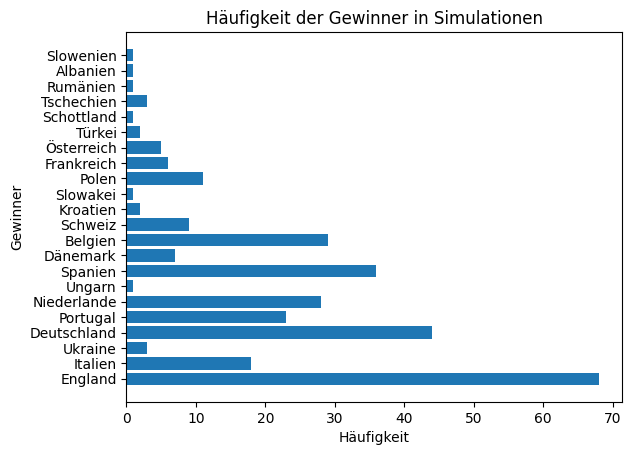

In [22]:
plt.barh(list(lst.keys()), lst.values())  # Horizontaler Balkendiagramm
plt.xlabel('Häufigkeit')
plt.ylabel('Gewinner')
plt.title('Häufigkeit der Gewinner in Simulationen')
plt.show()

In [23]:
print("Chance das die Schweiz die EM gewinnt liegt bei:", lst["Schweiz"]/n * 100, "%")
print("Anzahl der Simulationen:", n)

Chance das die Schweiz die EM gewinnt liegt bei: 2.0 %
Anzahl der Simulationen: 300


In [ ]:
# def ko_quali_list(group_rangking, groups = ["A", "B", "C", "D", "E", "F"]):
#     winner = []

#     for group in groups:
#         if 


#def ko_simulation():
      
 
    
  
# def ko_winners():

    

# def final_simulation():
    

# def simulation(data, repetitions):


In [ ]:
# TO DO:
# - create all functions
# - make this file a heler file
# - run the simulation in a new file called simulation
# - calc the possibility that Switzerland wins the EC